# Assignment A3.1

Import cleaned data set from previous notebook

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
sns.set()

In [2]:
df = pd.read_csv('data/cleaned_full_set.csv')

1) Separating df into a categorical_df and numeric_df with just the features, excluding also the loan_status columns which will be used as target variable later

In [3]:
#https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9
object_df = df.select_dtypes(include='object')
categorical_df = object_df[['grade', 'listing_title']]
#use 'term' as categorical too, it has just three unique values, parse to string or pd.get_dummies() wont get it
categorical_df['term'] = df['term'].astype('category')
numeric_df = df[['amount_borrowed', 'borrower_rate','installment', 'late_fees_paid', 'debt_sale_proceeds_received']]

2) Transforming categorical_df into binary dummies (necessary for PCA)

In [4]:
binary_df = pd.get_dummies(categorical_df)

3) Concatenating dfs into feature_df (X)

In [7]:
feature_df = pd.concat([numeric_df, binary_df], axis=1)
feature_df = feature_df.drop(['late_fees_paid', 'debt_sale_proceeds_received'],axis=1)
#feature_df = binary_df

In [8]:
feature_df.head()

,amount_borrowed,borrower_rate,installment,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,...,listing_title_moving,listing_title_other,listing_title_renewable_energy,listing_title_small_business,listing_title_unknown,listing_title_vacation,listing_title_wedding,term_12,term_36,term_60
0,27050.0,0.1099,885.46,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4800.0,0.1099,157.13,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,12000.0,0.0762,373.94,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,12000.0,0.1199,398.52,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,12000.0,0.0662,368.45,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Thinking about it, I'm also dropping late fees paid and debt_sale_proceeds_received as these are features that in practice wouldn't be possible to use as input features to predict the likeness of a loan to be good or bad for business

4) Slicing column to be used as target_df 

In [9]:
target_df = df['status_binary']

In [10]:
target_df.value_counts()

1    2554682
0     320464
Name: status_binary, dtype: int64

5) Getting a 10% sample of the main set

In [11]:
main_df = pd.concat([feature_df,target_df],axis=1)
sample_df = main_df.sample(frac=0.1)

In [51]:
sample_df.to_csv('data/sample_df.csv', index=False)

6) Get X (feature space) and y (target space) **I'm just doing this for standard practice, I feel more comfortable using these names for the objects**

In [12]:
X = sample_df.iloc[:,:-1]
y = sample_df.iloc[:,-1]

In [16]:
y.value_counts()

1    255202
0     32313
Name: status_binary, dtype: int64

7) Reduce X space into 2 dimensions

In [17]:
pca = PCA(n_components=2).fit_transform(X)

8) Split pca reduced set into train and test sets **(For later)**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)

9) Split non-pca reduced set into train and test sets (For later at random forest classifier)

In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=0)

### Some graphical exploration 

Checking out how the raw pca clusters

Text(0, 0.5, 'PC2')

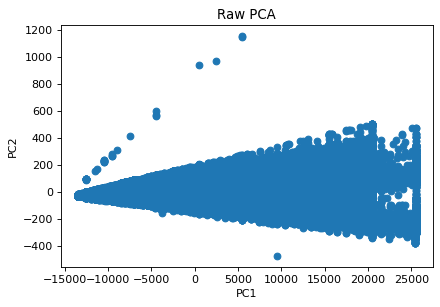

In [18]:
plt.figure(dpi=80)
plt.scatter(pca[:,0],pca[:,1])
plt.title('Raw PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

Interesting... there is clearly some kind of grouping at work, now, let's check with colors!

Text(0, 0.5, 'PC2')

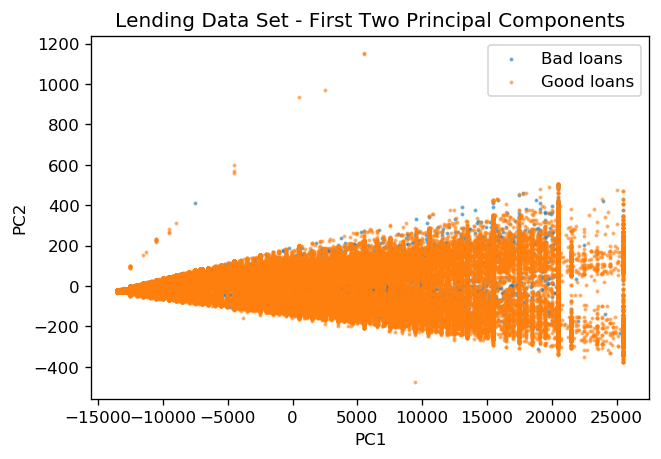

In [19]:
plt.figure(dpi=120)
#Scatter plot PC for only the Bad loans (y.values==0)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='Bad loans', s=2)
#Scatter plot PC for only the Good loans (y.values==1)
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Good loans', s=2)
plt.legend()
plt.title('Lending Data Set - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

Ok...classes are heavily imbalanced and based on the PCA we'll clearly have a hard time distinguishing them by eye even, so we'll jump into decision trees (random forest) as this is a model known for its capacity to manage classification tasks on **imbalanced datasets** and also **mixed type datasets**. Which is kind of the case.

https://elitedatascience.com/imbalanced-classes

In [20]:
from sklearn.ensemble import RandomForestClassifier

Pass non-PCA transformed data or we'll see nothing of real trascendence

In [39]:
model = RandomForestClassifier()
model.fit(X_train2,y_train2)

RandomForestClassifier()

In [40]:
# Predict on training set
pred_y = model.predict(X_train2)
# Is our model predicting just one class?
print(np.unique(pred_y))

[0 1]


In [41]:
# Predict on test set
pred_y = model.predict(X_test2)
# Is our model predicting just one class?
print(np.unique(pred_y))

[0 1]


Nope! It really isn't! how cool is that?

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
# Predict on training set
pred_y = model.predict(X_train2)
# How's our accuracy?
print(accuracy_score(y_train2, pred_y))

0.9272245821662431


In [44]:
# Predict on test set
pred_y = model.predict(X_test2)
# How's our accuracy?
print(accuracy_score(y_test2, pred_y))

0.8695863882357852


**Pretty badass** RandomForest is where is at! I'm telling ya

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
# What about AUROC? (train set)
prob_y = model.predict_proba(X_train2)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_train2, prob_y))

0.9323276972829284


In [47]:
# What about AUROC? (test set)
prob_y = model.predict_proba(X_test2)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_test2, prob_y))

0.6610532973812494


Ok, on test set auroc is kinda low, so there is some overfit to account for... (But still, 66% its not that low, I've seen worse). I can try to look into that overfit, but at least I have a working model for now. Let's see that feature importance analysis...

In [50]:
# Feature names
features = X_train2.columns

# Ranking calification of Decistion Tree model
ranking = model.feature_importances_

zipped = list(zip(features, ranking))

df = pd.DataFrame(zipped, columns = ['Feature', 'Ranking']) 
   
# Order data according to ranking
df.sort_values(by='Ranking', ascending=False)

,Feature,Ranking
2,installment,0.380768
1,borrower_rate,0.297576
0,amount_borrowed,0.245168
3,grade_A,0.008520
7,grade_E,0.006265
8,grade_F,0.005963
12,listing_title_debt_consolidation,0.005352
6,grade_D,0.004942
4,grade_B,0.004880
5,grade_C,0.004745


Time terms and listing titles have close to no importance on classification. Maybe I should try dropping them and see how the metrics perform after the change